# Convolutional Neural Network

## Importing the libraries

In [37]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [38]:
tf.__version__

'2.12.0'

## 1. Data Import

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import struct
from array import array
import numpy as np

def read_idx3(filename):
    with open(filename, 'rb') as f:
        magic = struct.unpack('>I', f.read(4))[0]
        if magic != 2051:
            raise ValueError('Invalid magic number for file "{}": {}'.format(filename, magic))
        num_images = struct.unpack('>I', f.read(4))[0]
        num_rows = struct.unpack('>I', f.read(4))[0]
        num_cols = struct.unpack('>I', f.read(4))[0]
        data = array('B', f.read())
    images = np.zeros((num_images, num_rows, num_cols), dtype=np.uint8)
    for i in range(num_images):
        images[i] = np.array(data[i*num_rows*num_cols:(i+1)*num_rows*num_cols]).reshape((num_rows, num_cols))
    return images

In [41]:
import struct
from array import array
def read_idx1(filename):
  # Open the labels file in binary mode
  with open(filename, 'rb') as f:
      # Read the first 8 bytes of the file to get the magic number and number of labels
      magic, num_labels = struct.unpack('>II', f.read(8))
      if magic != 2049:
          raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
      print('Magic number:', magic)
      print('Number of labels:', num_labels)
      # Read the labels into an array of unsigned bytes
      labels = array('B', f.read())
  return labels

In [42]:
training_images = read_idx3('/content/drive/MyDrive/Colab Notebooks/ML/HW13_Final Project CNN/archive/train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels = read_idx1('/content/drive/MyDrive/Colab Notebooks/ML/HW13_Final Project CNN/archive/train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images = read_idx3('/content/drive/MyDrive/Colab Notebooks/ML/HW13_Final Project CNN/archive/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels = read_idx1('/content/drive/MyDrive/Colab Notebooks/ML/HW13_Final Project CNN/archive/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

Magic number: 2049
Number of labels: 60000
Magic number: 2049
Number of labels: 10000


In [43]:
import matplotlib.pyplot as plt

def show_images(images, labels, string_text):
    n = 5
    cols = 5
    rows = (n + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(28, 28))
    axs = axs.ravel()
    for i in range(n):
        axs[i].imshow(images[i], cmap=plt.cm.gray)
        axs[i].set_title(string_text +'[' + str(i) + '] = ' + str(labels[i]))
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

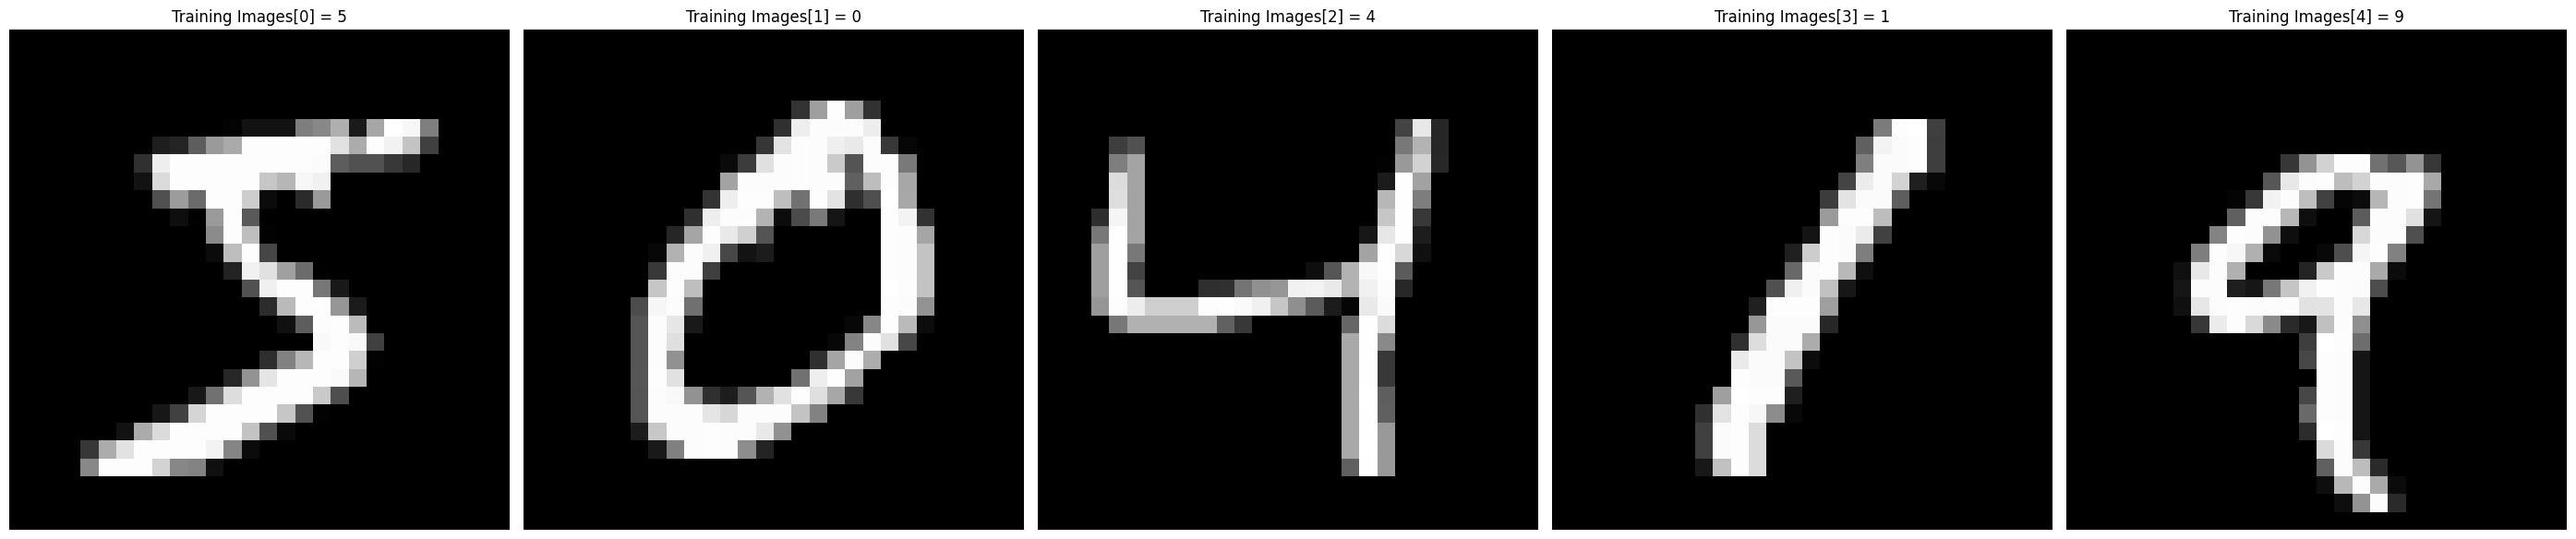

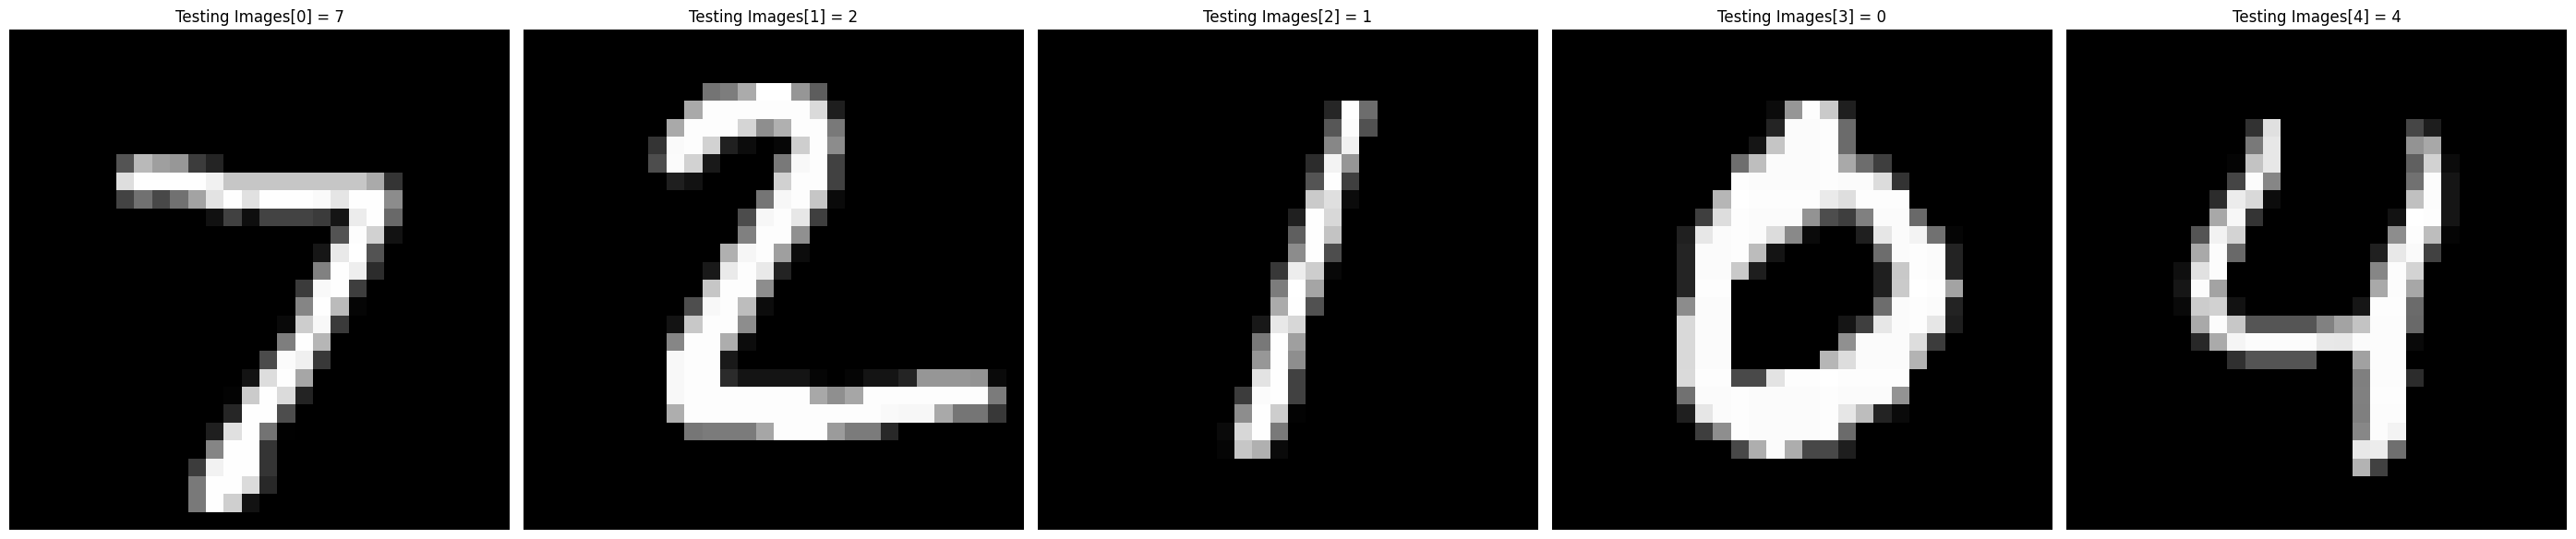

In [44]:
show_images(training_images, training_labels, "Training Images")
show_images(test_images, test_labels, "Testing Images")

## 2. Data Preprocessing

In [45]:
from sklearn.model_selection import train_test_split

# Splitting the training_images dataset into training and validation datasets
training_images, validation_images, training_labels, validation_labels = train_test_split(training_images, training_labels, test_size=0.4, random_state=10)

In [46]:
from keras.utils import to_categorical

# One-hot encode the labels
num_classes = 10  # Or any other number of classes
training_labels = to_categorical(training_labels, num_classes)
validation_labels = to_categorical(validation_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [47]:
training_images = np.reshape(training_images, (training_images.shape[0], 28, 28, 1))
test_images = np.reshape(test_images, (test_images.shape[0], 28, 28, 1))

In [48]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
training_images = np.array(training_images)
training_labels = np.array(training_labels)  
training_set = train_datagen.flow(training_images, training_labels, batch_size=32)

In [49]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
testing_set = train_datagen.flow(test_images, test_labels, batch_size=32)

In [50]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)
validation_set = validation_datagen.flow(test_images, test_labels, batch_size=32)

## 3. Building the CNN Model

In [51]:
def define_model():
    # Define a sequential model
    model = tf.keras.models.Sequential()
    # Add a 2D convolutional layer with 32 filters, 3x3 kernel size, ReLU activation, He uniform kernel initializer, and input shape of 28x28x1
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    # Add a max pooling layer with 2x2 pool size
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # Add a 2D convolutional layer with 64 filters, 3x3 kernel size, ReLU activation, and He uniform kernel initializer
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_uniform'))
    # Add a max pooling layer with 2x2 pool size
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # Flatten the output of the convolutional layers
    model.add(tf.keras.layers.Flatten())
    # Add a dense layer with 100 units, ReLU activation, and He uniform kernel initializer
    model.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
    # Add a dense output layer with 10 units and softmax activation
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    # Compile the model using SGD optimizer with learning rate of 0.01, momentum of 0.9, categorical crossentropy loss, and accuracy metric
    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    # Print the model summary
    model.summary()
    # Return the compiled model
    return model

## 4. Training the CNN Model

In [52]:
# Define an early stopping callback to stop training if validation loss does not improve after 3 epochs and restore the best weights
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True)

In [53]:
# Define a model using the define_model function and fit it to the training set
model = define_model()
model.fit(training_set, epochs=30, batch_size=32, validation_data=validation_set, callbacks=[early_stop])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 100)              

## 5. Making Single Predicion and Batch Prediction

### Single Prediction

In [54]:
test_image = test_images[0]
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(f"Predicted Results :" + str(result.argmax()))
print(f"Test Label :" + str(test_labels[0].argmax()))

1/1 [==============================] - 0s 82ms/step
Predicted Results :7
Test Label :7


### Batch Prediction

In [55]:
# model.evaluate() method is used to evaluate the performance of a trained model on a given dataset
score = model.evaluate(testing_set)
# score[0] corresponds to the loss value of the model on the testing dataset.
print("Test loss:", score[0])
# score[1] corresponds to the accuracy value of the model on the testing dataset.
print("Test accuracy:", score[1])

313/313 [==============================] - 6s 19ms/step - loss: 0.0470 - accuracy: 0.9850
Test loss: 0.04700896516442299
Test accuracy: 0.9850000143051147
